In [89]:
%reload_ext autoreload
%autoreload 2

import hashlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import yaml

from firebase_admin import db
from library.config import get_config_declaration, get_config_options
from library.firebase import initialize_app, get_dataset_ref
from matplotlib.axes import Axes
from os import makedirs
from os.path import exists, basename, splitext
from typing import Dict, Tuple
from library.dataset import get_dataset_path
from glob import glob
import cv2

from library.design_space import get_design_space as get_design_space2, get_pareto_front

In [90]:
VIDEO_FILES = [
    "VISO/car/003",
    "VISO/car/004",
    "VISO/car/005",
    "VISO/car/006",
    "VISO/car/007",
    "VISO/car/008",
    "VISO/car/009",
]

VIDEO_SCORES = {
    "VISO/car/003": (0.92, 0.92, 0.84),
    "VISO/car/004": (0.83, 0.89, 0.85),
    "VISO/car/005": (0.94, 0.88, 0.91),
    "VISO/car/006": (0.88, 0.93, 0.86),
    "VISO/car/007": (0.80, 0.84, 0.80),
    "VISO/car/008": (0.83, 0.85, 0.81),
    "VISO/car/009": (0.93, 0.73, 0.78)
}

initialize_app()

In [91]:
def get_design_space(
    video_file: str, enable_tracking: bool, enable_persist: bool
):
    X, y, current_idx, known_idx = get_design_space2(video_file, enable_tracking, enable_persist)

    with open("./config_declaration.yml", "rb") as f:
        config_hash = hashlib.md5(f.read()).hexdigest()

    sherlock_ref = db.reference("sherlock")

    video_file_ref = get_dataset_ref(video_file, sherlock_ref)
    config_declaration_ref = video_file_ref.child(config_hash)

    if enable_tracking:
        tracking_ref = config_declaration_ref.child("tracking_enabled")
    else:
        tracking_ref = config_declaration_ref.child("tracking_disabled")

    if enable_persist:
        persist_ref = tracking_ref.child("persist_enabled")
    else:
        persist_ref = tracking_ref.child("persist_disabled")

    current_idx = np.array(current_idx)
    current_outputs = np.array(y[current_idx, :])

    known_idx = np.array(known_idx)
    known_outputs = np.array(y[known_idx, :])
        
    ypredict, ypredict_idx, = get_pareto_front(video_file, enable_tracking, enable_persist)

    return y, current_idx, current_outputs, known_outputs, known_idx, ypredict, ypredict_idx, persist_ref

def get_results(
    video_file: str,
    enable_tracking: bool,
    enable_persist: bool,
    reference_video_file: str,
    ax: Axes,
):
    if reference_video_file:
        reference_video_idx = VIDEO_FILES.index(reference_video_file)

    video_idx = VIDEO_FILES.index(video_file)

    (
        y,
        current_idx,
        current_outputs,
        known_outputs,
        known_idx,
        ypredict,
        ypredict_idx,
        storage_ref,
    ) = get_design_space(video_file, enable_tracking, enable_persist)

    ax.scatter(
        current_outputs[:, 0],
        current_outputs[:, 1],
        c="blue",
        marker="^",
        label="Sampled designs",
    )
    ax.scatter(
        ypredict[:, 0],
        ypredict[:, 1],
        c="red",
        label="Predicted Pareto designs",
    )

    if reference_video_file and video_idx != reference_video_idx:
        _, _, _, _, _, _, ref_ypredict_idx, _ = get_design_space(
            reference_video_file, enable_tracking, enable_persist
        )

        known_idx_set = {idx for idx in known_idx}
        filtered_idx = [idx for idx in ref_ypredict_idx if idx in known_idx_set]
        requested_idx = [
            int(idx) for idx in ref_ypredict_idx if idx not in known_idx_set
        ]

        requested_idx_ref = storage_ref.child("requested_idx")
        requested_idx_ref.set(requested_idx)

        ax.scatter(
            y[filtered_idx, 0],
            y[filtered_idx, 1],
            c="orange",
            marker="+",
            label=f"Predicted Pareto designs for Video {reference_video_idx + 1}",
        )

    ax.set_title(
        f"Video {video_idx + 1}"
        # + f" with Tracking {'Enabled' if enable_tracking else 'Disabled'}"
        # + f" and Persistence {'Enabled' if enable_persist else 'Disabled'}"
        # + " Design Space"
    )
    ax.set(xlabel="Recall", ylabel="Precision")
    # ax.label_outer()
    # ax.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1.05))
    # plt.xlabel("Recall")
    # plt.ylabel("Precision")
    ax.set_xlim(known_outputs[:, 0].min(), known_outputs[:, 0].max())
    ax.set_ylim(known_outputs[:, 1].min(), known_outputs[:, 1].max())

    # plt.show()

In [92]:
def get_row_col(i: int):
    col = i % 3
    row = math.floor(i / 3)

    return (row, col)

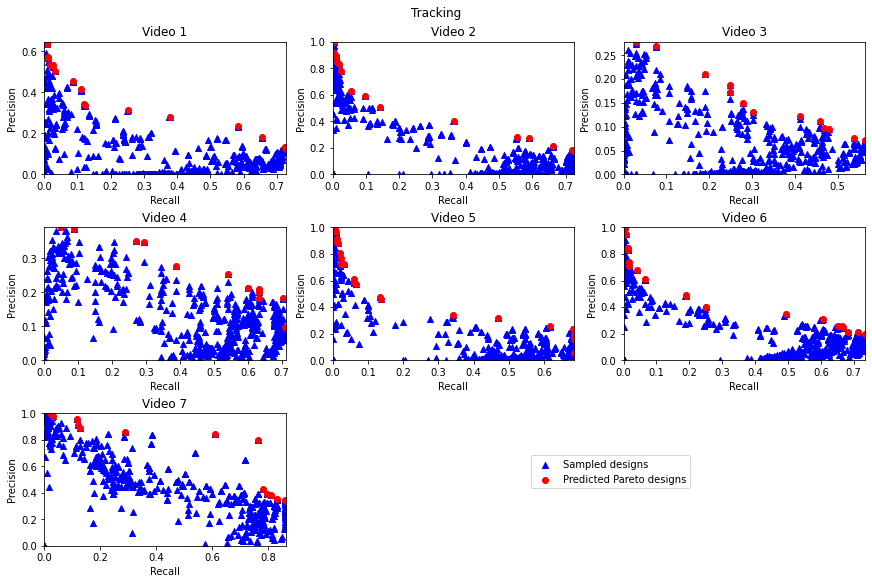

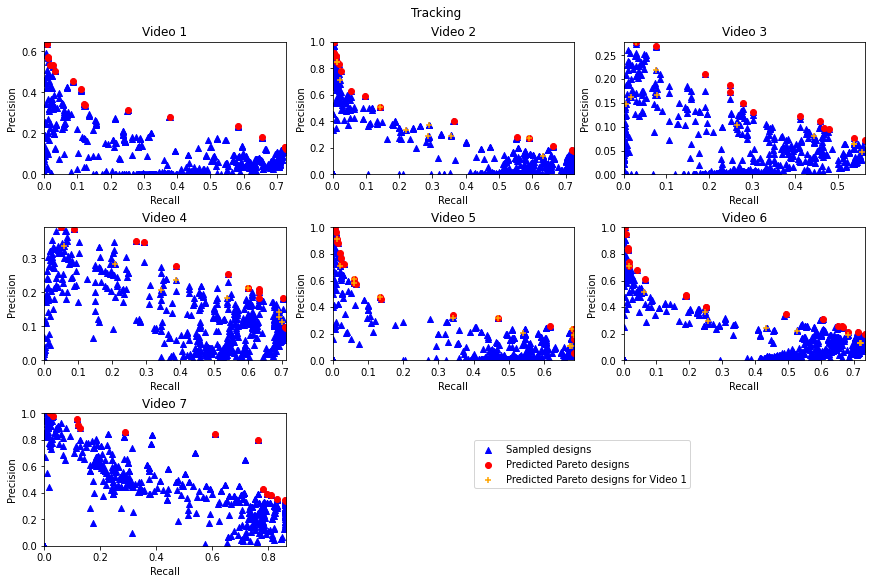

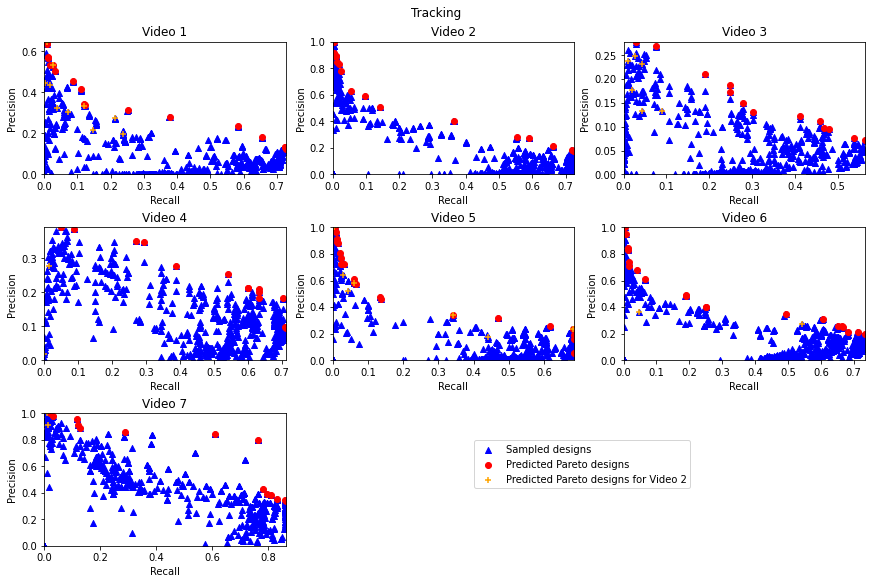

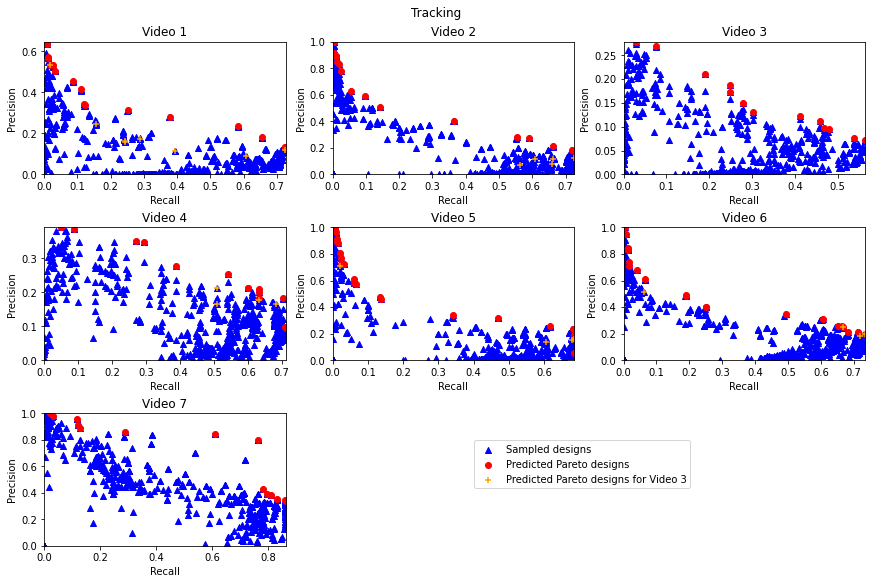

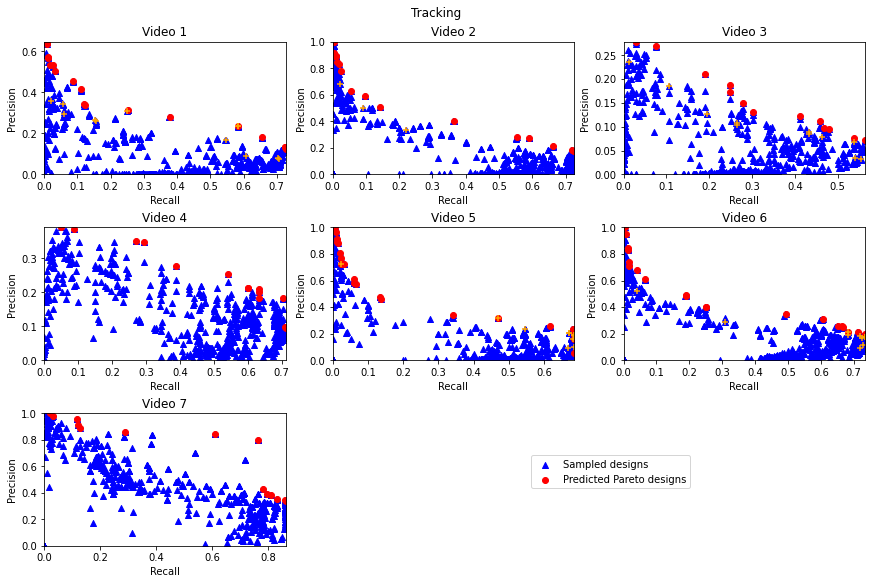

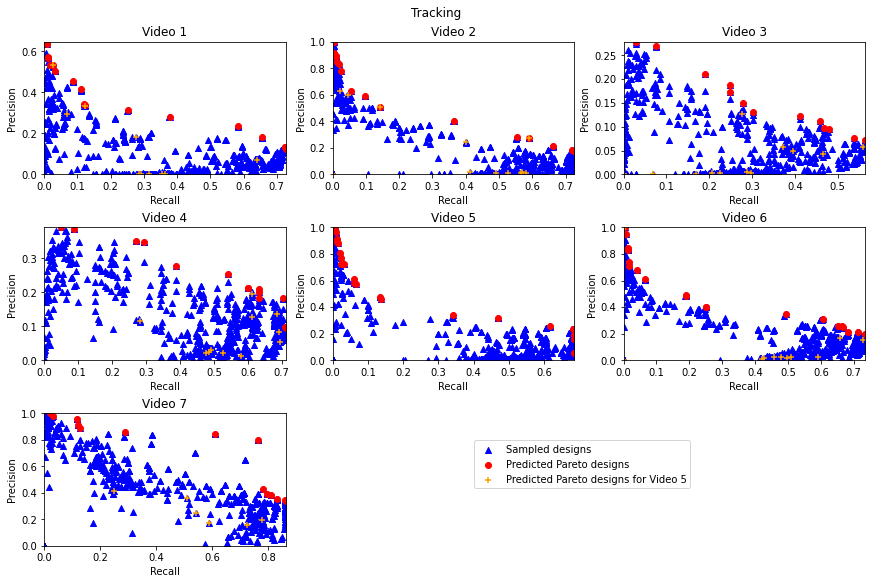

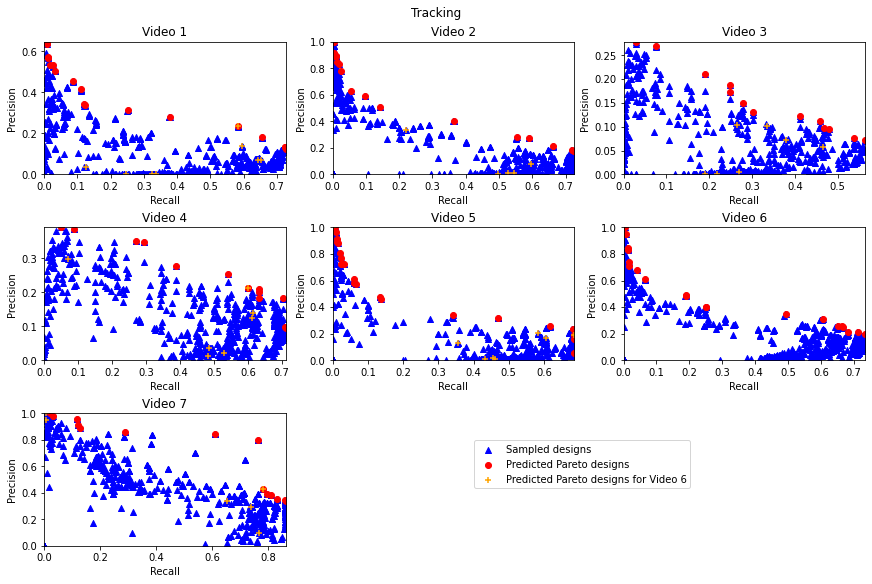

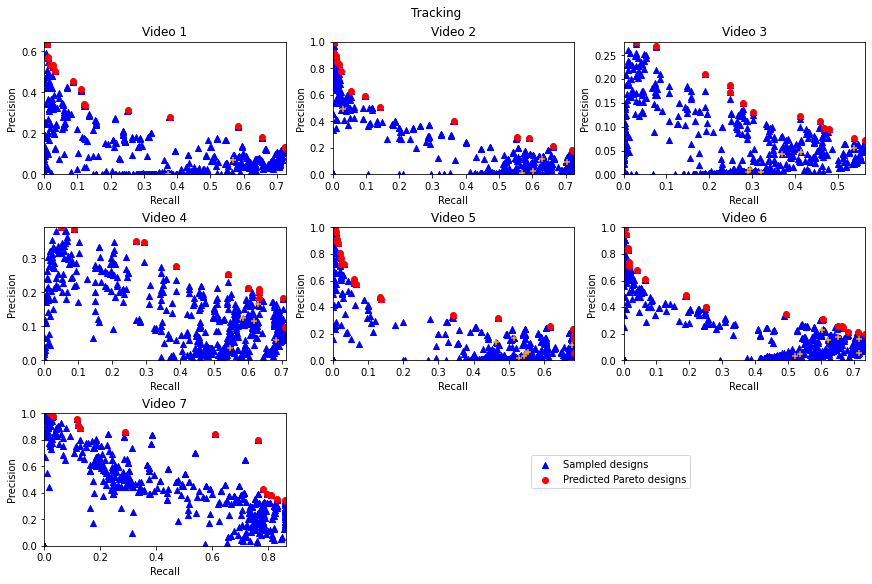

In [93]:
def plot_pareto(enable_tracking: bool, enable_persist: bool):
    video_files = [None]
    video_files.extend(VIDEO_FILES)

    for ref_idx, ref_video_file in enumerate(video_files):
        ref_idx -= 1
        if ref_idx != -1:
            ref_r, ref_c = get_row_col(ref_idx)

            if ref_r == 0 and ref_c == 0:
                ref_r = 1

        fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8), constrained_layout=True)
        fig.delaxes(axs[2][1])
        fig.delaxes(axs[2][2])
        for i, video_file in enumerate(VIDEO_FILES):
            r, c = get_row_col(i)

            get_results(
                video_file, enable_tracking, enable_persist, ref_video_file, axs[r, c]
            )

        if ref_idx == -1:
            ref_r = 0

        handles, labels = axs[ref_r, 0].get_legend_handles_labels()
        fig.legend(
            handles, labels, loc="lower right", bbox_to_anchor=(0.8, 0.15)
        )

        makedirs("./output/figures", exist_ok=True)

        if ref_idx == -1:
            path = f"./output/figures/fig_viso_{'tracking' if enable_tracking else 'detection'}_pareto"
        else:
            path = f"./output/figures/fig_viso_{'tracking' if enable_tracking else 'detection'}_pareto_ref{ref_idx + 1}"

        fig.suptitle(f"{'Tracking' if enable_tracking else 'Detection'}")
        plt.savefig(f"{path}.pdf", format="pdf")
        plt.savefig(f"{path}.png", format="png")

plot_pareto(True, False)
# plot_pareto(False, False)

In [94]:
def save_pareto(enable_tracking: bool, enable_persist: bool):
    names = []
    idxes = []
    recalls = []
    precisions = []
    f1s = []

    for i, video_file in enumerate(VIDEO_FILES):
        (
            y,
            current_idx,
            current_outputs,
            _,
            _,
            ypredict,
            ypredict_idx,
            storage_ref,
        ) = get_design_space(video_file, enable_tracking, enable_persist)

        for idx, (output) in zip(current_idx, current_outputs):
            idx = idx
            recall = output[0]
            precision = output[1]
            f1 = output[2]

            names.append(f"Video {i + 1}")
            idxes.append(idx)
            recalls.append(recall)
            precisions.append(precision)
            f1s.append(f1)

    df = pd.DataFrame()
    df["Video Name"] = names
    df["idx"] = idxes
    df["Recall"] = recalls
    df["Precision"] = precisions
    df["F1"] = f1s

    df.to_csv(f"./output/{'tracking' if enable_tracking else 'detection'}_pareto_front.csv")

save_pareto(True, False)
# save_pareto(False, False)

In [95]:
def print_results(enable_tracking: bool, enable_persist: bool):
    # print("=" * 3 + ("Tracking" if enable_tracking else "Detection") + "=" * 3)

    avg_recall = np.zeros(3)
    avg_precision = np.zeros(3)
    avg_f1 = np.zeros(3)

    required_avg_recall = 0.84
    required_avg_precision = 0.85
    required_avg_f1 = 0.84

    for video_file in VIDEO_FILES:
        (
            _,
            _,
            _,
            _,
            _,
            ypredict,
            ypredict_idx,
            storage_ref,
        ) = get_design_space(video_file, enable_tracking, enable_persist)

        max_recall_idx = np.argmax(ypredict[:, 0])
        max_precision_idx = np.argmax(ypredict[:, 1])
        max_f1_idx = np.argmax(ypredict[:, 2])

        max_recall = ypredict[max_recall_idx, :]
        max_precision = ypredict[max_precision_idx, :]
        max_f1 = ypredict[max_f1_idx, :]

        max_recall_idx = ypredict_idx[max_recall_idx]
        max_precision_idx = ypredict_idx[max_precision_idx]
        max_f1_idx = ypredict_idx[max_f1_idx]

        avg_recall += max_recall
        avg_precision += max_precision
        avg_f1 += max_f1

        largest_possible_f1 = [max_recall[0], max_precision[1], (2 * max_recall[0] * max_precision[1]) / (max_recall[0] + max_precision[1])]

        recall_color = "\033[0m"
        precision_color = "\033[0m"
        f1_color = "\033[0m"
        largest_possible_f1_color = "\033[0m"

        recall, precision, f1 = VIDEO_SCORES[video_file]

        if max_recall[0] >= recall:
            recall_color = "\033[94m"

        if max_precision[1] >= precision:
            precision_color = "\033[94m"

        if max_f1[2] >= f1:
            f1_color = "\033[94m"

        if largest_possible_f1[2] >= f1:
            largest_possible_f1_color = "\033[94m"

        print(video_file)
        # print(f"{recall_color}({max_recall_idx}) Max Recall: {max_recall}\033[0m => {recall}")
        # print(f"{precision_color}({max_precision_idx}) Max Precision: {max_precision}\033[0m => {precision}")
        print(f"{f1_color}({max_f1_idx}) Max F1: {max_f1}\033[0m => {f1}")
        # print(f"{largest_possible_f1_color}Largest Possible F1: {largest_possible_f1}\033[0m => {f1}")
        print("=" * 10)

    avg_recall /= 7.0
    avg_precision /= 7.0
    avg_f1 /= 7.0

    recall_color = "\033[0m"
    precision_color = "\033[0m"
    f1_color = "\033[0m"

    recall, precision, f1 = VIDEO_SCORES[video_file]

    if avg_recall[0] >= required_avg_recall:
        recall_color = "\033[94m"

    if avg_precision[1] >= required_avg_precision:
        precision_color = "\033[94m"

    if avg_f1[2] >= required_avg_f1:
        f1_color = "\033[94m"

    print("Average")
    # # print(f"{recall_color}Max Recall: {avg_recall}\033[0m => {required_avg_recall}")
    # # print(f"{precision_color}Max Precision: {avg_precision}\033[0m => {required_avg_precision}")
    print(f"{f1_color}Max F1: {avg_f1}\033[0m => {required_avg_f1}")
    # print("=" * 10)

print_results(True, False)
#print_results(False, False)

VISO/car/003
(11065) Max F1: [0.58350515 0.2338843  0.3339233 ] => 0.84
VISO/car/004
(1285) Max F1: [0.36363636 0.40650407 0.38387716] => 0.85
VISO/car/005
(15682) Max F1: [0.24850657 0.18654709 0.21311475] => 0.91
VISO/car/006
(18260) Max F1: [0.54166667 0.25490196 0.34666667] => 0.86
VISO/car/007
(5153) Max F1: [0.46889226 0.31987578 0.38030769] => 0.8
VISO/car/008
(4555) Max F1: [0.60515021 0.3119469  0.41167883] => 0.81
VISO/car/009
(11911) Max F1: [0.76315789 0.7992126  0.78076923] => 0.78
Average
Max F1: [0.51064502 0.35898181 0.40719109] => 0.84


In [96]:

# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8), constrained_layout=True)
# fig.delaxes(axs[2][1])
# fig.delaxes(axs[2][2])

# for i, video_file in enumerate(VIDEO_FILES):
#     r, c = get_row_col(i)
#     video_idx = VIDEO_FILES.index(video_file)

#     track_ypredict, _ = get_pareto_front(video_file, True, False)
#     track_ypredict_order = np.argsort(track_ypredict[:, 0])
#     track_ypredict = track_ypredict[track_ypredict_order, :]

#     detect_ypredict, _ = get_pareto_front(video_file, False, False)
#     detect_ypredict_order = np.argsort(detect_ypredict[:, 0])
#     detect_ypredict = detect_ypredict[detect_ypredict_order, :]

#     axs[r, c].plot(
#         track_ypredict[:, 0],
#         track_ypredict[:, 1],
#         c="red",
#         marker="o",
#         label="Spot (Track)",
#     )
#     axs[r, c].hlines(y=track_ypredict[0, 1], xmin=0, xmax=track_ypredict[0, 0], color='red')
#     axs[r, c].vlines(x=track_ypredict[-1, 0], ymin=0, ymax=track_ypredict[-1, 1], color='red')

#     axs[r, c].plot(
#         detect_ypredict[:, 0],
#         detect_ypredict[:, 1],
#         c="blue",
#         marker="o",
#         label="Spot (Detect)",
#     )
#     axs[r, c].hlines(y=detect_ypredict[0, 1], xmin=0, xmax=detect_ypredict[0, 0], color='blue')
#     axs[r, c].vlines(x=detect_ypredict[-1, 0], ymin=0, ymax=detect_ypredict[-1, 1], color='blue')

#     axs[r, c].set_title(f"Video {video_idx + 1}")
#     axs[r, c].set(xlabel="Recall", ylabel="Precision")
    
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(
#     handles, labels, loc="lower right", bbox_to_anchor=(0.8, 0.15)
# )
# plt.savefig("./output/figures/fig_viso_pr_curve.pdf", format="pdf")
# plt.savefig("./output/figures/fig_viso_pr_curve.png", format="png")

In [97]:
track_areas = []
detect_areas = []

for i, video_file in enumerate(VIDEO_FILES):
    track_ypredict, _ = get_pareto_front(video_file, True, False)
    track_ypredict_order = np.argsort(track_ypredict[:, 0])
    track_ypredict = track_ypredict[track_ypredict_order, :]

    # detect_ypredict, _ = get_pareto_front(video_file, False, False)
    # detect_ypredict_order = np.argsort(detect_ypredict[:, 0])
    # detect_ypredict = detect_ypredict[detect_ypredict_order, :]

    track_area = np.trapz(track_ypredict[:, 1], x=track_ypredict[:, 0])
    # detect_area = np.trapz(detect_ypredict[:, 1], x=detect_ypredict[:, 0])

    track_area += track_ypredict[0, 0] * track_ypredict[0, 1]
    # detect_area += detect_ypredict[0, 0] * detect_ypredict[0, 1]

    track_areas.append(track_area)
    # detect_areas.append(detect_area)

    print(f"Track: {track_area:.2}")
    # print(f"Track: {track_area:.2}, Detect {detect_area:.2}")

avg_track_area = np.average(track_areas)
# avg_detect_area = np.average(detect_areas)

print(f"Avg Track: {avg_track_area: .2}")
# print(f"Avg Track: {avg_track_area: .2}, Avg Detect: {avg_detect_area: .2}")

Track: 0.22
Track: 0.3
Track: 0.097
Track: 0.21
Track: 0.27
Track: 0.3
Track: 0.7
Avg Track:  0.3


In [98]:
min_size = []
max_size = []

for video_file in VIDEO_FILES:
    dataset_path = get_dataset_path(video_file)
    ground_truth_path = f"{dataset_path}/gt/gt.txt"

    gt = pd.read_csv(ground_truth_path).to_numpy()[:, 4:6]
    min_size.extend(np.min(gt, axis=1))
    max_size.extend(np.max(gt, axis=1))

avg_size = (np.average(min_size), np.average(max_size))
print(avg_size)

(5.612623580529376, 7.18343443672467)


In [99]:
def clamp(value: int, min_value: int, max_value: int):
    if value <= min_value:
        return min_value

    if value >= max_value:
        return max_value

    return value

In [100]:
contrasts = []

for video_file in VIDEO_FILES:
    dataset_path = get_dataset_path(video_file)
    img_path = f"{dataset_path}/img"
    ground_truth_path = f"{dataset_path}/gt/gt.txt"

    frames = glob(f"{img_path}/*.jpg")
    gt = pd.read_csv(ground_truth_path).to_numpy()[:, :6].astype(float)

    for frame_path in frames:
        frame_number = int(splitext(basename(frame_path))[0])
        frame_gt = gt[gt[:, 0] == frame_number, 2:6]
        frame_img = cv2.imread(frame_path)

        img_height, img_width, _ = frame_img.shape

        for x1, y1, width, height in frame_gt:
            x2 = x1 + width + width / 2
            y2 = y1 + height + height / 2

            x1 -= width + width / 2
            y1 -= height + width / 2

            x1 = clamp(x1, 0, x1)
            y1 = clamp(y1, 0, y1)

            x1 = round(x1)
            y1 = round(y1)

            x2 = round(x2)
            y2 = round(y2)

            x2 = clamp(x2, x2, img_width - 1)
            y2 = clamp(y2, y2, img_height - 1)

            region = cv2.cvtColor(frame_img[y1:y2, x1:x2, :], cv2.COLOR_BGR2GRAY).flatten().astype(float) / 255.0
            contrasts.append(np.std(region))

print(np.average(contrasts))

0.17103572399584593


In [101]:
X, y, current_idx, known_idx = get_design_space2(VIDEO_FILES[0], True, False)

print(X.shape)

(19200, 6)


In [102]:
samples = []

for video_file in VIDEO_FILES:
    _, track_current_idx, _, _, _, _, track_ypredict_idx, _ = get_design_space(video_file, True, False)
    # _, detect_current_idx, _, _, _, _, detect_ypredict_idx, _ = get_design_space(video_file, False, False)

    samples.extend(track_current_idx.shape)
    # samples.extend(detect_current_idx.shape)

print(np.average(samples))

624.8571428571429
